# Originally from Mertics for Distinguishing Orbital Precession from Tidal Decay via Transit and Occultation Timing
## Editing to add TESS data - RMH 

In [1]:
# Analyzing transit-timing data from A-thano+ (2022 - https://iopscience.iop.org/article/10.3847/1538-3881/ac416d)

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from utils import *
from fit_lin_model_to_prec_ephemeris import *

from astropy.time import Time

Ps_precession = 2.797440 # days
T0_precession = 2455642.14436 - 2450000. # BJD
omega_0 = -0.30 # rad
domega_dE = 0.0143 # rad/orbit
e = 0.0013
Pa_precession = Ps_precession/(1. - 1./2./np.pi*domega_dE)

T0_precession_unc_plus = 0.00042
T0_precession_unc_minus = -0.0004

Ps_precession_unc_plus = 0.000001
Ps_precession_unc_minus = 0.000001

omega_0_unc_plus = 0.51
omega_0_unc_minus = -0.65

domega_dE_unc_plus = 0.0009
domega_dE_unc_minus = -0.0007

e_unc_plus = 0.0005
e_unc_minus = -0.0004

precession_unc = np.sqrt([T0_precession_unc_plus**2 + T0_precession_unc_minus**2,
                          Ps_precession_unc_plus**2 + Ps_precession_unc_minus**2,
                          e_unc_plus**2 + e_unc_minus**2,
                          omega_0_unc_plus**2 + omega_0_unc_minus**2,
                          domega_dE_unc_plus**2 + domega_dE_unc_minus**2])

T0_decay = 2455642.14322
T0_decay_unc_plus = 0.00058
T0_decay_unc_minus = -0.00057

Ps_decay = 2.797445
Ps_decay_unc_plus = 0.000002
Ps_decay_unc_minus = -0.000002

dPdE_decay = -7.e-9 # days per orbit
dPdE_decay_unc_plus = 3e-9
dPdE_decay_unc_minus = -3e-9

decay_unc = np.sqrt([T0_decay_unc_plus**2 + T0_decay_unc_minus**2,
                     Ps_decay_unc_plus**2 + Ps_decay_unc_minus**2,
                     dPdE_decay_unc_plus**2 + dPdE_decay_unc_minus**2])

In [25]:
def pull_all_data():
    # add in tess data
    t_data = np.genfromtxt("tess_hatp37b_allsector_fits.csv", delimiter=',', names=True, skip_header=1)
    t_data["Tm"] -= 2450000. 
    # add sectors in numerically
    # tess_sectors = ["41", "53", "54", "55", "80", "82"]  
    # for s in tess_sectors: 
    #     f = f"tess_hatp37_S{s}_fits.csv"
    #     t_data_new = np.genfromtxt(f, delimiter=",", names=True)
    #     t_data_new["Tm"] -= 2450000.  # time shift in A-thano 2022
    #     t_data = np.concatenate((t_data, t_data_new))

    # print(t_data)

    filename = "Athano2022_Table6.csv"
    a_data = np.genfromtxt(filename, delimiter=',', names=True)

    name = "best_fit_values_HAT-P-37b.csv"
    e_data = np.genfromtxt(name, delimiter=",", names=True, skip_header=4)
    e_data["Tm"] -= 2450000. 

    initial_data = np.concatenate((a_data, t_data, e_data))
    sort_idx = np.argsort(initial_data["Epoch"])
    data = initial_data[sort_idx]
    # filter_mask = np.argwhere(sort_data["sigma_Tm"] <= 0.00150)
    # data = sort_data[filter_mask].flatten()
    # print(data)
    return data

T0, Ps, e, omega_0, domega_dE: 
[ 5.64214388e+03  2.79744145e+00  9.85063707e-04 -8.69965064e-01
  1.52192813e-02]
[1.93096113e-04 2.02269401e-07 2.18270642e-04 3.18811029e-01
 4.27551138e-04]
num_sig discrepancy: 
[-0.78366654  1.01715758 -0.46554293 -0.64361123  0.7549308 ]
BIC for linear with all points:  338.3962278338455
final Delta BIC with all points +- unc:  58.29937536807154 13.19090595827292
[330.] [2.54880029]
final Delta BIC w/o outliers +- unc:  30.66424104679311 13.114877048604


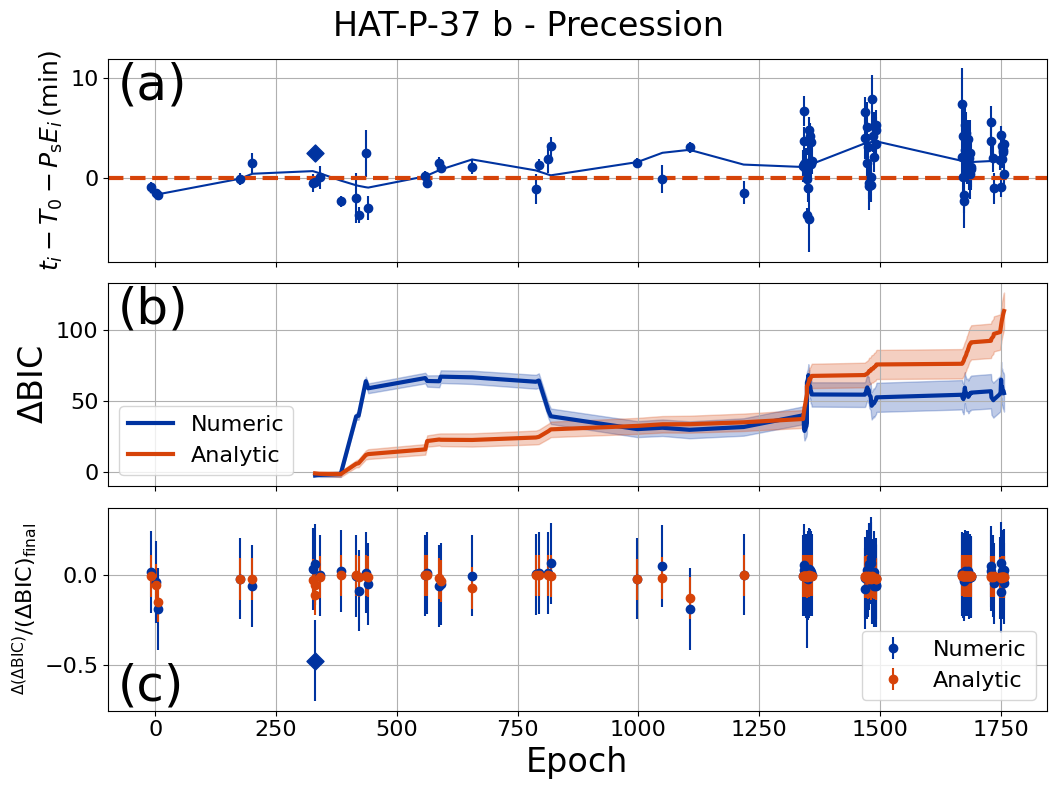

In [29]:
num_prec_params = 5.
num_lin_params = 2.

# filename = "Athano2022_Table6.csv"
# data = np.genfromtxt(filename, delimiter=',', names=True)
data = pull_all_data()  # concatenate of tess data and athano data

fig = plt.figure(figsize=(6*aspect_ratio, 8))
fig.suptitle("HAT-P-37 b - Precession", fontsize=24)
# ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212, sharex=ax1)
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312, sharex=ax1)
ax3 = fig.add_subplot(313, sharex=ax1)

# Using A-Thano's numbers
# popt = [T0_precession, Ps_precession, e, omega_0, domega_dE]
# print("old popt: ", popt)

popt, pcov = curve_fit(calc_ttra_precession, data['Epoch'], data['Tm'], sigma=data['sigma_Tm'], 
                       p0=[T0_precession, Ps_precession, e, omega_0, domega_dE], method='trf')
unc = np.sqrt(np.diag(pcov))
saved_popt = popt
saved_prec_popt = popt

print("T0, Ps, e, omega_0, domega_dE: ")
print(popt)
print(unc)

print("num_sig discrepancy: ")
print((popt - [T0_precession, Ps_precession, e, omega_0, domega_dE])/np.sqrt(unc**2 + precession_unc**2))
# Fit a linear model
lin_coeffs = np.polyfit(data['Epoch'], data['Tm'], 1, w=1./data['sigma_Tm'])
saved_lin_coeffs = lin_coeffs

prec_BIC = calc_BIC(data['Tm'], calc_ttra_precession(data['Epoch'], *popt), deg=num_prec_params, sd=data['sigma_Tm'])
saved_prec_BIC_all_points = prec_BIC
saved_sigma_prec_BIC_all_points = np.sqrt(2.*(len(data['Epoch']) - (num_prec_params)))
lin_BIC = calc_BIC(data['Tm'], np.polyval(lin_coeffs, data['Epoch']), deg=num_lin_params, sd=data['sigma_Tm'])
print("BIC for linear with all points: ", lin_BIC)
final_Delta_BIC = lin_BIC - prec_BIC
error_bars = np.sqrt(2.*(len(data['Epoch']) - (num_prec_params + num_lin_params)))

print("final Delta BIC with all points +- unc: ", final_Delta_BIC, error_bars)

saved_popt = popt

cosw = np.cos(saved_popt[4]*data['Epoch'] + saved_popt[3])

# O - C using best-fit linear portion of precession model
ax1.errorbar(data['Epoch'], (data['Tm'] - np.polyval([Ps_precession, T0_precession], data['Epoch']))*24.*60., 
             yerr=data['sigma_Tm']*24.*60., ls='', marker='o', color=BoiseState_blue)
ax1.plot(data['Epoch'], (calc_ttra_precession(data['Epoch'], *popt) - np.polyval([Ps_precession, T0_precession], data['Epoch']))*24.*60., 
         color=BoiseState_blue)

ax1.axhline(0., color=BoiseState_orange, lw=3, ls='--')

# Running Delta BIC
running_Delta_BIC = np.array([])
sigma_running_anal_Delta_BIC = np.array([])
running_anal_Delta_BIC = np.array([])

ind = np.full(len(data['Epoch']), False, dtype=bool)

for i in range(7, len(data['Epoch'])):    
    popt, pcov = curve_fit(calc_ttra_precession, data['Epoch'][:i], data['Tm'][:i], sigma=data['sigma_Tm'][:i], 
                       p0=[T0_precession, Ps_precession, e, omega_0, domega_dE], method='trf')
    lin_coeffs = np.polyfit(data['Epoch'][:i], data['Tm'][:i], 1, w=1./data['sigma_Tm'][:i])

    prec_BIC = calc_BIC(data['Tm'][:i], calc_ttra_precession(data['Epoch'][:i], *popt), deg=num_prec_params, sd=data['sigma_Tm'][:i])
    lin_BIC = calc_BIC(data['Tm'][:i], np.polyval(lin_coeffs, data['Epoch'][:i]), deg=num_lin_params, sd=data['sigma_Tm'][:i])

    Delta_T0_prime = calc_T0_lin_factor(data['Epoch'][:i], cosw[:i], data['sigma_Tm'][:i])
    Delta_Ps_prime = calc_Ps_lin_factor(data['Epoch'][:i], cosw[:i], data['sigma_Tm'][:i])
    anal_lin_chi_sq = (e*Pa_precession/np.pi)**2*np.sum((cosw[:i] +\
                                                         Delta_Ps_prime*data['Epoch'][:i] + Delta_T0_prime)**2/data['sigma_Tm'][:i]**2) +\
        (len(data['Epoch'][:i]) - 2.)

    anal_lin_fit_BIC = anal_lin_chi_sq + num_lin_params*np.log(len(data['Epoch'][:i]))
    anal_prec_BIC = (len(data['Epoch'][:i]) - num_prec_params) + num_prec_params*np.log(len(data['Epoch'][:i]))

    running_Delta_BIC = np.append(running_Delta_BIC, lin_BIC - prec_BIC)
    running_anal_Delta_BIC = np.append(running_anal_Delta_BIC, anal_lin_fit_BIC - anal_prec_BIC)
    sigma_running_anal_Delta_BIC = np.append(sigma_running_anal_Delta_BIC, 
                                             np.sqrt(2.*(len(data['Epoch'][:i]) - (num_prec_params + num_lin_params))))
    
ax2.plot(data['Epoch'][7:], running_Delta_BIC, lw=3, color=BoiseState_blue, label="Numeric")
ax2.fill_between(data['Epoch'][7:], running_Delta_BIC - sigma_running_anal_Delta_BIC, running_Delta_BIC + sigma_running_anal_Delta_BIC, 
                 color=BoiseState_blue, alpha=0.25)
ax2.plot(data['Epoch'][7:], running_anal_Delta_BIC, lw=3, color=BoiseState_orange, label="Analytic")
ax2.fill_between(data['Epoch'][7:], running_anal_Delta_BIC - sigma_running_anal_Delta_BIC, running_anal_Delta_BIC + sigma_running_anal_Delta_BIC, 
                 color=BoiseState_orange, alpha=0.25)

### Panel b ###

### Panel c ###

# prec_BIC = calc_BIC(data['Tm'], calc_ttra_precession(data['Epoch'], *saved_popt), deg=num_prec_params, sd=data['sigma_Tm'])
# lin_BIC = calc_BIC(data['Tm'], np.polyval(saved_lin_coeffs, data['Epoch']), deg=num_lin_params, sd=data['sigma_Tm'])
# final_Delta_BIC = lin_BIC - prec_BIC

# Analytic expectation
Delta_T0_prime = calc_T0_lin_factor(data['Epoch'], cosw, data['sigma_Tm'])
Delta_Ps_prime = calc_Ps_lin_factor(data['Epoch'], cosw, data['sigma_Tm'])
anal_lin_chi_sq = (e*Pa_precession/np.pi)**2*np.sum((cosw + Delta_Ps_prime*data['Epoch'] + Delta_T0_prime)**2/data['sigma_Tm']**2) +\
    (len(data['Epoch']) - 2.)
anal_lin_fit_BIC = anal_lin_chi_sq + num_lin_params*np.log(len(data['Epoch']))
anal_prec_BIC = (len(data['Epoch']) - num_prec_params) + num_prec_params*np.log(len(data['Epoch']))
final_anal_Delta_BIC = anal_lin_fit_BIC - anal_prec_BIC

Delta_Delta_BIC = np.zeros(len(data))
anal_Delta_Delta_BIC = np.zeros(len(data))
for i in range(len(data)):
    ind = np.array([True for i in range(len(data))])
    ind[i] = False

    popt, pcov = curve_fit(calc_ttra_precession, data['Epoch'][ind], data['Tm'][ind], sigma=data['sigma_Tm'][ind], 
                       p0=[T0_precession, Ps_precession, e, omega_0, domega_dE], method='trf')
    lin_coeffs = np.polyfit(data['Epoch'][ind], data['Tm'][ind], 1, w=1./data['sigma_Tm'][ind])
    
    prec_BIC = calc_BIC(data['Tm'][ind], calc_ttra_precession(data['Epoch'][ind], *popt), deg=num_prec_params, sd=data['sigma_Tm'][ind])
    lin_BIC = calc_BIC(data['Tm'][ind], np.polyval(lin_coeffs, data['Epoch'][ind]), deg=num_lin_params, sd=data['sigma_Tm'][ind])

    Delta_Delta_BIC[i] = (lin_BIC - prec_BIC) - final_Delta_BIC

    # Analytic expectation
    Delta_T0_prime = calc_T0_lin_factor(data['Epoch'][ind], cosw[ind], data['sigma_Tm'][ind])
    Delta_Ps_prime = calc_Ps_lin_factor(data['Epoch'][ind], cosw[ind], data['sigma_Tm'][ind])
    anal_lin_chi_sq = (e*Pa_precession/np.pi)**2*np.sum((cosw[ind] +\
                                                         Delta_Ps_prime*data['Epoch'][ind] + Delta_T0_prime)**2/data['sigma_Tm'][ind]**2) +\
        (len(data['Epoch'][ind]) - 2.)

    anal_lin_fit_BIC = anal_lin_chi_sq + num_lin_params*np.log(len(data['Epoch'][ind]))
    anal_prec_BIC = (len(data['Epoch'][ind]) - num_prec_params) + num_prec_params*np.log(len(data['Epoch'][ind]))

    anal_Delta_Delta_BIC[i] = (anal_lin_fit_BIC - anal_prec_BIC) - final_anal_Delta_BIC
    
error_bars = np.sqrt(2.*(len(data['Epoch'] - 1) - (num_prec_params + num_lin_params)))*np.ones(len(data['Epoch']))
ax3.errorbar(data['Epoch'], Delta_Delta_BIC/final_Delta_BIC, yerr=error_bars/final_Delta_BIC,
             ls='', marker='o', color=BoiseState_blue, label="Numeric")
ax3.errorbar(data['Epoch'], anal_Delta_Delta_BIC/final_anal_Delta_BIC, yerr=error_bars/final_anal_Delta_BIC,
             ls='', marker='o', color=BoiseState_orange, label="Analytic")
    
# Let's toss Delta(Delta BIC) outliers
num = Delta_Delta_BIC/final_Delta_BIC
anal = anal_Delta_Delta_BIC/final_anal_Delta_BIC
num_err = error_bars/final_Delta_BIC
anal_err = error_bars/final_anal_Delta_BIC

ind = np.abs(num - anal)/np.sqrt(num_err**2 + anal_err**2) < 1.
saved_prec_ind = ind

inlier_ind = ind
# print(ind)
y = (data['Tm'] - np.polyval([Ps_precession, T0_precession], data['Epoch']))[~ind]*24.*60.
print(data["Epoch"][~ind], y)
ax1.scatter(data['Epoch'][~ind], y, 
            marker='D', s=75, color=BoiseState_blue, zorder=10)
ax3.scatter(data['Epoch'][~ind], (Delta_Delta_BIC/final_Delta_BIC)[~ind], 
            marker='D', s=75, color=BoiseState_blue, zorder=10)

popt, pcov = curve_fit(calc_ttra_precession, data['Epoch'][ind], data['Tm'][ind], sigma=data['sigma_Tm'][ind], 
                   p0=[T0_precession, Ps_precession, e, omega_0, domega_dE], method='trf')

# print(popt)

lin_coeffs = np.polyfit(data['Epoch'][ind], data['Tm'][ind], 1, w=1./data['sigma_Tm'][ind])

prec_BIC = calc_BIC(data['Tm'][ind], calc_ttra_precession(data['Epoch'][ind], *popt), deg=num_prec_params, sd=data['sigma_Tm'][ind])
lin_BIC = calc_BIC(data['Tm'][ind], np.polyval(lin_coeffs, data['Epoch'][ind]), deg=num_lin_params, sd=data['sigma_Tm'][ind])
final_Delta_BIC = lin_BIC - prec_BIC
saved_prec_final_BIC = prec_BIC
saved_sigma_prec_final_BIC = np.sqrt(2.*(len(data['Epoch'][ind]) - (num_prec_params)))
error_bars = np.sqrt(2.*(len(data['Epoch'][ind]) - (num_prec_params + num_lin_params)))

print("final Delta BIC w/o outliers +- unc: ", final_Delta_BIC, error_bars)

### Panel c ###

ax1.grid(True)
ax2.grid(True)
ax3.grid(True)

ax2.legend(loc='best', fontsize=16)
ax3.legend(loc='best', fontsize=16)

ax1.tick_params(labelbottom=False, labelsize=16)
ax2.tick_params(labelbottom=False, labelsize=16)
ax3.tick_params(labelsize=16)

ax1.set_ylabel(r'$t_i - T_0 - P_{\rm s} E_i\,\left( {\rm min}\right)$', fontsize=18)
ax2.set_ylabel(r'$\Delta {\rm BIC}$', fontsize=24)
ax3.set_ylabel(r'$^{\Delta \left( \Delta {\rm BIC} \right)}/{\left( \Delta {\rm BIC} \right)_{\rm final}}$', fontsize=16)
ax3.set_xlabel("Epoch", fontsize=24)

ax1.text(0.01, 0.8, "(a)", fontsize=36, transform=ax1.transAxes)
ax2.text(0.01, 0.8, "(b)", fontsize=36, transform=ax2.transAxes)
ax3.text(0.01, 0.05, "(c)", fontsize=36, transform=ax3.transAxes)

# ax1.set_xlim(1730, 1760)
# ax3.set_ylim([-0.5, 0.25])

plt.tight_layout()
plt.show()
# fig.savefig("../figures/OmniPlot_HAT-P-37b_Precession.jpg", dpi=300, bbox_inches="tight")

T0, Ps, dPdE: 
[ 5.64214339e+03  2.79744294e+00 -1.72549001e-09]
[1.85186335e-04 6.55761986e-07 7.80466424e-10]
Discrepancy with Athanos: 
[ 0.21352813 -0.73001141  1.24321393]
lin_BIC:  338.3962278338455
final Delta BIC for prec - quad w/ all points +- unc: 
-46.05627818344823 18.973665961010276
final Delta BIC with all points +- unc:  12.24309718462331 13.341664064126334


/var/folders/5x/3m15_9vs2lnbtzh3mhf4mdlc0000gn/T/ipykernel_12080/3440880518.py:60: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(calc_ttra_decay, data['Epoch'][:i], data['Tm'][:i], sigma=data['sigma_Tm'][:i],
/var/folders/5x/3m15_9vs2lnbtzh3mhf4mdlc0000gn/T/ipykernel_12080/3440880518.py:75: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(2.*(len(data['Epoch'][:i]) - (num_quad_params + num_lin_params))))


final_Delta_BIC:  12.24309718462331
final_anal_Delta_BIC:  13.243098337908492
final quad params w/o outliers: 
[ 5.64214339e+03  2.79744294e+00 -1.72549001e-09]
[1.85186335e-04 6.55761986e-07 7.80466424e-10]
final Delta BIC prec - quad w/o outliers +- unc: 
-73.98348547665074 18.920887928424502
final Delta BIC w/o outliers +- unc: 
326.1531306492222 338.3962278338455
12.24309718462331 13.341664064126334
Comparing quad to prec Delta BIC (saved_quad_final_BIC - saved_prec_final_BIC): 
326.1531306492222 252.16964517257145
73.98348547665074


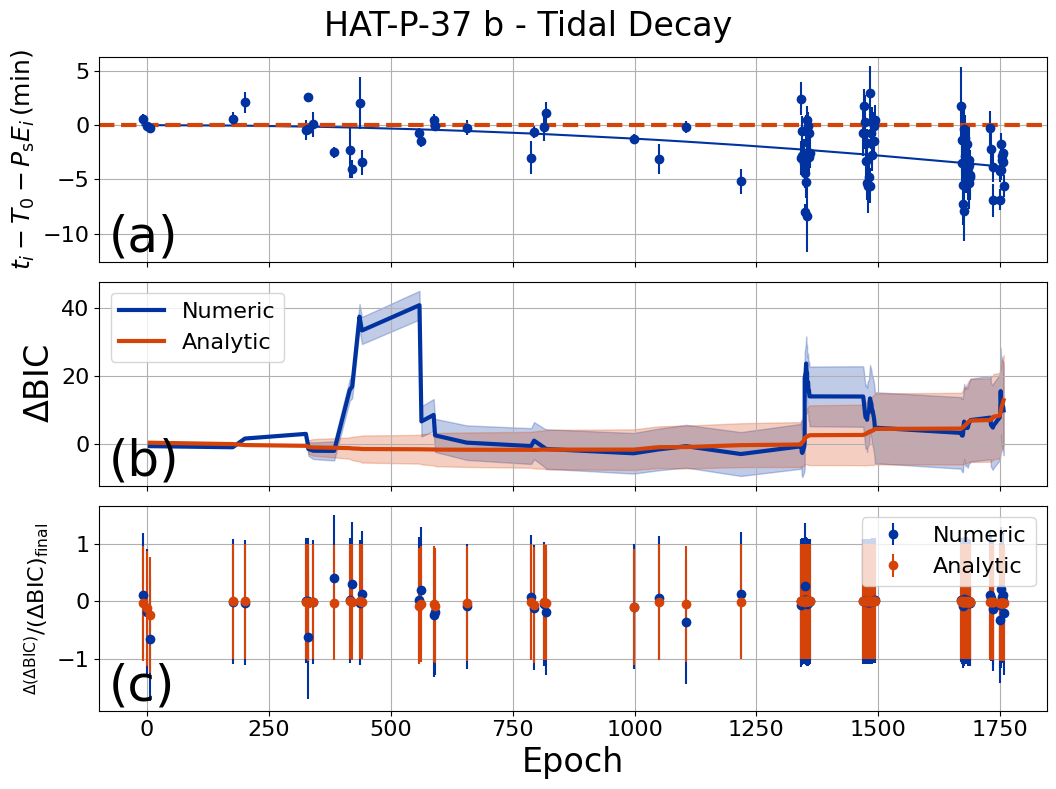

In [27]:
num_quad_params = 3.
num_lin_params = 2.

# filename = "Athano2022_Table6.csv"
data = pull_all_data()

fig = plt.figure(figsize=(6*aspect_ratio, 8))
fig.suptitle("HAT-P-37 b - Tidal Decay", fontsize=24)
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312, sharex=ax1)
ax3 = fig.add_subplot(313)

popt, pcov = curve_fit(calc_ttra_decay, data['Epoch'], data['Tm'], sigma=data['sigma_Tm'], 
                       p0=[T0_precession, Ps_precession, 0.], method='trf')
unc = np.sqrt(np.diag(pcov))
saved_popt = popt
saved_quad_popt = popt

print("T0, Ps, dPdE: ")
print(popt)
print(unc)

print("Discrepancy with Athanos: ")
# Need to build in offset in T0
print(((popt + [2450000., 0., 0.]) - [T0_decay, Ps_decay, dPdE_decay])/decay_unc)

# Fit a linear model
lin_coeffs = np.polyfit(data['Epoch'], data['Tm'], 1, w=1./data['sigma_Tm'])
saved_lin_coeffs = lin_coeffs

quad_BIC = calc_BIC(data['Tm'], calc_ttra_decay(data['Epoch'], *saved_popt), deg=num_quad_params, sd=data['sigma_Tm'])
lin_BIC = calc_BIC(data['Tm'], np.polyval(lin_coeffs, data['Epoch']), deg=num_lin_params, sd=data['sigma_Tm'])
print("lin_BIC: ", lin_BIC)
saved_quad_BIC_all_points = quad_BIC
saved_sigma_quad_BIC_all_points = np.sqrt(2.*(len(data['Epoch']) - (num_quad_params)))

print("final Delta BIC for prec - quad w/ all points +- unc: ")
print(saved_prec_BIC_all_points - saved_quad_BIC_all_points, 
      np.sqrt(saved_sigma_prec_BIC_all_points**2 + saved_sigma_quad_BIC_all_points**2))

final_Delta_BIC = lin_BIC - quad_BIC
error_bars = np.sqrt(2.*(len(data['Epoch']) - (num_quad_params + num_lin_params)))

print("final Delta BIC with all points +- unc: ", final_Delta_BIC, error_bars)

# O - C using best-fit linear portion of tidal model
ax1.errorbar(data['Epoch'], (data['Tm'] - np.polyval([saved_popt[1], saved_popt[0]], data['Epoch']))*24.*60., 
             yerr=data['sigma_Tm']*24.*60., ls='', marker='o', color=BoiseState_blue)
ax1.plot(data['Epoch'], (calc_ttra_decay(data['Epoch'], *saved_popt) - np.polyval([saved_popt[1], saved_popt[0]], data['Epoch']))*24.*60., 
         color=BoiseState_blue)

ax1.axhline(0., color=BoiseState_orange, lw=3, ls='--')

# Running Delta BIC
running_Delta_BIC = np.array([])
sigma_running_anal_Delta_BIC = np.array([])
running_anal_Delta_BIC = np.array([])

for i in range(2, len(data['Epoch'])):    
    popt, pcov = curve_fit(calc_ttra_decay, data['Epoch'][:i], data['Tm'][:i], sigma=data['sigma_Tm'][:i], 
                       p0=saved_popt, method='trf')
    lin_coeffs = np.polyfit(data['Epoch'][:i], data['Tm'][:i], 1, w=1./data['sigma_Tm'][:i])

    quad_BIC = calc_BIC(data['Tm'][:i], calc_ttra_decay(data['Epoch'][:i], *popt), deg=num_quad_params, sd=data['sigma_Tm'][:i])
    lin_BIC = calc_BIC(data['Tm'][:i], np.polyval(lin_coeffs, data['Epoch'][:i]), deg=num_lin_params, sd=data['sigma_Tm'][:i])

    anal_lin_chi_sq = calc_analytic_chisq(data['Epoch'][:i], data['sigma_Tm'][:i], saved_popt[2])

    anal_lin_fit_BIC = anal_lin_chi_sq + num_lin_params*np.log(len(data['Epoch'][:i]))
    anal_quad_BIC = (len(data['Epoch'][:i]) - num_quad_params) + num_quad_params*np.log(len(data['Epoch'][:i]))

    running_Delta_BIC = np.append(running_Delta_BIC, lin_BIC - quad_BIC)
    running_anal_Delta_BIC = np.append(running_anal_Delta_BIC, anal_lin_fit_BIC - anal_quad_BIC)
    sigma_running_anal_Delta_BIC = np.append(sigma_running_anal_Delta_BIC, 
                                             np.sqrt(2.*(len(data['Epoch'][:i]) - (num_quad_params + num_lin_params))))
    
ax2.plot(data['Epoch'][2:], running_Delta_BIC, lw=3, color=BoiseState_blue, label="Numeric")
ax2.fill_between(data['Epoch'][2:], running_Delta_BIC - sigma_running_anal_Delta_BIC, running_Delta_BIC + sigma_running_anal_Delta_BIC, 
                 color=BoiseState_blue, alpha=0.25)
ax2.plot(data['Epoch'][2:], running_anal_Delta_BIC, lw=3, color=BoiseState_orange, label="Analytic")
ax2.fill_between(data['Epoch'][2:], running_anal_Delta_BIC - sigma_running_anal_Delta_BIC, running_anal_Delta_BIC + sigma_running_anal_Delta_BIC, 
                 color=BoiseState_orange, alpha=0.25)

# # ### Panel b ###

# # ### Panel c ###

quad_BIC = calc_BIC(data['Tm'], calc_ttra_decay(data['Epoch'], *saved_popt), deg=num_quad_params, sd=data['sigma_Tm'])
lin_BIC = calc_BIC(data['Tm'], np.polyval(saved_lin_coeffs, data['Epoch']), deg=num_lin_params, sd=data['sigma_Tm'])
final_Delta_BIC = lin_BIC - quad_BIC
print("final_Delta_BIC: ", final_Delta_BIC)

# Analytic expectation
anal_lin_chi_sq = calc_analytic_chisq(data['Epoch'], data['sigma_Tm'], saved_popt[2])
anal_lin_fit_BIC = anal_lin_chi_sq + num_lin_params*np.log(len(data['Epoch']))
anal_quad_BIC = (len(data['Epoch']) - num_quad_params) + num_quad_params*np.log(len(data['Epoch']))
final_anal_Delta_BIC = anal_lin_fit_BIC - anal_quad_BIC
print("final_anal_Delta_BIC: ", final_anal_Delta_BIC)

Delta_Delta_BIC = np.zeros(len(data))
anal_Delta_Delta_BIC = np.zeros(len(data))
for i in range(len(data)):
    ind = np.array([True for i in range(len(data))])
    ind[i] = False

    popt, pcov = curve_fit(calc_ttra_decay, data['Epoch'][ind], data['Tm'][ind], sigma=data['sigma_Tm'][ind], 
                       p0=saved_popt, method='trf')
    lin_coeffs = np.polyfit(data['Epoch'][ind], data['Tm'][ind], 1, w=1./data['sigma_Tm'][ind])
    
    quad_BIC = calc_BIC(data['Tm'][ind], calc_ttra_decay(data['Epoch'][ind], *popt), deg=num_quad_params, sd=data['sigma_Tm'][ind])
    lin_BIC = calc_BIC(data['Tm'][ind], np.polyval(lin_coeffs, data['Epoch'][ind]), deg=num_lin_params, sd=data['sigma_Tm'][ind])

    Delta_Delta_BIC[i] = (lin_BIC - quad_BIC) - final_Delta_BIC

    # Analytic expectation
    anal_lin_chi_sq = calc_analytic_chisq(data['Epoch'][ind], data['sigma_Tm'][ind], saved_popt[2])

    anal_lin_fit_BIC = anal_lin_chi_sq + num_lin_params*np.log(len(data['Epoch'][ind]))
    anal_quad_BIC = (len(data['Epoch'][ind]) - num_quad_params) + num_quad_params*np.log(len(data['Epoch'][ind]))

    anal_Delta_Delta_BIC[i] = (anal_lin_fit_BIC - anal_quad_BIC) - final_anal_Delta_BIC
    
# print("Careful!! You have used final_Delta_BIC in place of the final_anal_Delta_BIC!!")
error_bars = np.sqrt(2.*(len(data['Epoch'] - 1) - (num_quad_params + num_lin_params)))*np.ones(len(data['Epoch']))
ax3.errorbar(data['Epoch'], Delta_Delta_BIC/final_Delta_BIC, yerr=error_bars/final_Delta_BIC,
             ls='', marker='o', color=BoiseState_blue, label="Numeric")
ax3.errorbar(data['Epoch'], anal_Delta_Delta_BIC/final_anal_Delta_BIC, yerr=error_bars/final_anal_Delta_BIC,
             ls='', marker='o', color=BoiseState_orange, label="Analytic")
    
# Let's toss Delta(Delta BIC) outliers
num = Delta_Delta_BIC/final_Delta_BIC
anal = anal_Delta_Delta_BIC/final_anal_Delta_BIC
num_err = error_bars/final_Delta_BIC
anal_err = error_bars/final_anal_Delta_BIC

ind = np.abs(num - anal)/np.sqrt(num_err**2 + anal_err**2) < 1.
saved_quad_ind = ind

inlier_ind = ind

ax1.scatter(data['Epoch'][~ind], (data['Tm'] - np.polyval([saved_popt[1], saved_popt[0]], data['Epoch']))[~ind]*24.*60., 
            marker='D', s=75, color=BoiseState_blue, zorder=10)
ax3.scatter(data['Epoch'][~ind], (Delta_Delta_BIC/final_Delta_BIC)[~ind], 
            marker='D', s=75, color=BoiseState_blue, zorder=10)

popt, pcov = curve_fit(calc_ttra_decay, data['Epoch'][inlier_ind], data['Tm'][inlier_ind], sigma=data['sigma_Tm'][inlier_ind], 
                   p0=saved_popt, method='trf')
unc = np.sqrt(np.diag(pcov))
print("final quad params w/o outliers: ")
print(popt)
print(unc)
lin_coeffs = np.polyfit(data['Epoch'][ind], data['Tm'][ind], 1, w=1./data['sigma_Tm'][ind])

quad_BIC = calc_BIC(data['Tm'][inlier_ind], calc_ttra_decay(data['Epoch'][inlier_ind], *popt), deg=num_quad_params, sd=data['sigma_Tm'][inlier_ind])
saved_quad_final_BIC = quad_BIC
saved_sigma_quad_final_BIC = np.sqrt(2.*(len(data['Epoch'][inlier_ind]) - (num_quad_params)))

print("final Delta BIC prec - quad w/o outliers +- unc: ")
print(saved_prec_final_BIC - saved_quad_final_BIC, 
      np.sqrt(saved_sigma_prec_final_BIC**2 + saved_sigma_quad_final_BIC**2))

lin_BIC = calc_BIC(data['Tm'][inlier_ind], np.polyval(lin_coeffs, data['Epoch'][inlier_ind]), deg=num_lin_params, sd=data['sigma_Tm'][inlier_ind])
final_Delta_BIC = lin_BIC - quad_BIC
error_bars = np.sqrt(2.*(len(data['Epoch'][inlier_ind]) - (num_quad_params + num_lin_params)))

print("final Delta BIC w/o outliers +- unc: ")
print(saved_quad_final_BIC, lin_BIC)
print(final_Delta_BIC, error_bars)

### Panel c ###

print("Comparing quad to prec Delta BIC (saved_quad_final_BIC - saved_prec_final_BIC): ")
print(saved_quad_final_BIC, saved_prec_final_BIC)
print(saved_quad_final_BIC - saved_prec_final_BIC)

ax1.grid(True)
ax2.grid(True)
ax3.grid(True)

ax2.legend(loc='best', fontsize=16)
ax3.legend(loc='best', fontsize=16)

ax1.tick_params(labelbottom=False, labelsize=16)
ax2.tick_params(labelbottom=False, labelsize=16)
ax3.tick_params(labelsize=16)

ax1.set_ylabel(r'$t_i - T_0 - P_{\rm s} E_i\,\left( {\rm min}\right)$', fontsize=18)
ax2.set_ylabel(r'$\Delta {\rm BIC}$', fontsize=24)
ax3.set_ylabel(r'$^{\Delta \left( \Delta {\rm BIC} \right)}/{\left( \Delta {\rm BIC} \right)_{\rm final}}$', fontsize=16)
ax3.set_xlabel("Epoch", fontsize=24)

ax1.text(0.01, 0.05, "(a)", fontsize=36, transform=ax1.transAxes)
ax2.text(0.01, 0.05, "(b)", fontsize=36, transform=ax2.transAxes)
ax3.text(0.01, 0.05, "(c)", fontsize=36, transform=ax3.transAxes)

# ax3.set_xlim([150, 250])
# ax3.set_ylim([-0.5, 0.25])

plt.tight_layout()
plt.show()
fig.savefig("../figures/OmniPlot_HAT-P-37b_TidalDecay.jpg", dpi=300, bbox_inches="tight")

In [ ]:
num_prec_params = 5.
num_quad_params = 3.
num_lin_params = 2.

filename = "Athano2022_Table6.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)

# transit and occultation predictions 
filename = "HAT-P-37_b_observing_campaign.csv"
prediction_data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)

# Be aware! This assumes a linear ephemeris
predicted_midtimes = np.array([0.5*(prediction_data['ingress'][i] + prediction_data['egress'][i]) 
                               for i in range(len(prediction_data))])
ind = prediction_data['type'] == 'transit'
predicted_transit_midtimes = predicted_midtimes[ind]
predicted_occultation_midtimes = predicted_midtimes[~ind]

predicted_transit_epochs = np.ceil((predicted_midtimes[ind] - (saved_prec_popt[0] + 2450000))/saved_prec_popt[1])
predicted_occultation_epochs = np.ceil((predicted_midtimes[~ind] -\
                                        ((saved_prec_popt[0] + 2450000) + saved_prec_popt[1]/2.))/saved_prec_popt[1])
predicted_all_epochs = np.array(np.sort([*predicted_transit_epochs, *predicted_occultation_epochs]))

# plt.scatter(predicted_occultation_epochs, (predicted_occultation_midtimes - (saved_popt[0] + 2450000 + saved_popt[1]/2.) - saved_popt[1]*predicted_occultation_epochs)*24.*60.)

fig = plt.figure(figsize=(6*aspect_ratio, 6))
# fig.suptitle("HAT-P-37 b", fontsize=24)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

### Analytic Delta BIC for Precession ###
running_Delta_BIC = np.array([])
sigma_running_anal_Delta_BIC = np.array([])
running_anal_Delta_BIC = np.array([])

# Restore data
filename = "Athano2022_Table6.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)
# Toss Delta(Delta BIC) outliers for precession
data = data[saved_prec_ind]
cosw = np.cos(saved_prec_popt[3] + saved_prec_popt[4]*data['Epoch'])

for i in range(7, len(data['Epoch'])):    

    Delta_T0_prime = calc_T0_lin_factor(data['Epoch'][:i], cosw[:i], data['sigma_Tm'][:i])
    Delta_Ps_prime = calc_Ps_lin_factor(data['Epoch'][:i], cosw[:i], data['sigma_Tm'][:i])
    anal_lin_chi_sq = (e*Pa_precession/np.pi)**2*np.sum((cosw[:i] +\
                                                         Delta_Ps_prime*data['Epoch'][:i] + Delta_T0_prime)**2/data['sigma_Tm'][:i]**2) +\
        (len(data['Epoch'][:i]) - 2.)

    anal_lin_fit_BIC = anal_lin_chi_sq + num_lin_params*np.log(len(data['Epoch'][:i]))
    anal_prec_BIC = (len(data['Epoch'][:i]) - num_prec_params) + num_prec_params*np.log(len(data['Epoch'][:i]))

    running_Delta_BIC = np.append(running_Delta_BIC, lin_BIC - prec_BIC)
    running_anal_Delta_BIC = np.append(running_anal_Delta_BIC, anal_lin_fit_BIC - anal_prec_BIC)
    if(len(data['Epoch'][:i]) >= 7):
        sigma_running_anal_Delta_BIC = np.append(sigma_running_anal_Delta_BIC, 
                                                 np.sqrt(2.*(len(data['Epoch'][:i]) - (num_prec_params + num_lin_params))))
    else:
        sigma_running_anal_Delta_BIC = np.append(sigma_running_anal_Delta_BIC, 0.)
    
ax1.plot(data['Epoch'][7:], running_anal_Delta_BIC, lw=3, color=BoiseState_blue, label="Precession")
# ax1.fill_between(data['Epoch'][7:], running_anal_Delta_BIC - sigma_running_anal_Delta_BIC, running_anal_Delta_BIC + sigma_running_anal_Delta_BIC, 
#                  color=BoiseState_blue, alpha=0.25)

ax1.axvspan(0, np.max(data['Epoch'][7:]), alpha=0.25, color='green')

### Extrapolate forward, dropping outliers ###

# Extrapolate forward, dropping outliers - scale down precision under the assumption that we will use smaller scopes
# A-thanos+ (2022) used a variety of scopes to collect additional transits and used a 50-cm scope to collect three transits
# and we'll assume that we can scale down by using a 10-cm Unistellar scope
# transit_timing_precision_reduction_factor = (50./11.4)**2
# transit_timing_precision_reduction_factor = 1.0

all_E_tra = np.array([*data['Epoch'], *predicted_transit_epochs])
# med_sigma_tra = np.median(data['sigma_Tm'])*transit_timing_precision_reduction_factor*np.ones(len(predicted_transit_epochs))
med_sigma_tra = (10./60./24.)*np.ones(len(predicted_transit_epochs)) # ten-minute timing precision
all_sigma_tra = np.array([*data['sigma_Tm'], *med_sigma_tra])
cosw_tra = np.cos(saved_prec_popt[4]*all_E_tra + saved_prec_popt[3])

# What Delta t for precession (in min)?
# ~ 2-min departure!
# ax2.plot(all_E_tra, saved_prec_popt[2]*saved_prec_popt[1]/np.pi*(24.*60.)*cosw_tra)
# cosw_tra = -0.1*np.ones_like(all_sigma_tra)

# Interpolate forward
for i in range(len(data['Epoch']), len(all_E_tra)):    
    Delta_T0_prime = calc_T0_lin_factor(all_E_tra[:i], cosw_tra[:i], all_sigma_tra[:i])
    Delta_Ps_prime = calc_Ps_lin_factor(all_E_tra[:i], cosw_tra[:i], all_sigma_tra[:i])
    anal_lin_chi_sq = (e*Pa_precession/np.pi)**2*np.sum((cosw_tra[:i] +\
                                                         Delta_Ps_prime*all_E_tra[:i] + Delta_T0_prime)**2/all_sigma_tra[:i]**2) +\
        (len(data['Epoch'][:i]) - 2.)

    anal_lin_fit_BIC = anal_lin_chi_sq + num_lin_params*np.log(len(all_E_tra[:i]))
    anal_prec_BIC = (len(all_E_tra[:i]) - num_prec_params) + num_prec_params*np.log(len(all_E_tra[:i]))

    running_Delta_BIC = np.append(running_Delta_BIC, lin_BIC - prec_BIC)
    running_anal_Delta_BIC = np.append(running_anal_Delta_BIC, anal_lin_fit_BIC - anal_prec_BIC)

ax1.scatter(predicted_transit_epochs[7:], running_anal_Delta_BIC[len(data['Epoch']):], 
            ls='', marker='o', alpha=0.5, color=BoiseState_blue)

### Analytic Delta BIC for Tidal Decay ###

### Extrapolate forward, dropping outliers ###
running_anal_Delta_BIC = np.array([])
sigma_running_anal_Delta_BIC = np.array([])

# Restore data
filename = "Athano2022_Table6.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)
data = data[saved_quad_ind]

all_E_tra = np.array([*data['Epoch'], *predicted_transit_epochs])
med_sigma_tra = (10./60./24.)*np.ones(len(predicted_transit_epochs)) # ten-minute timing precision
all_sigma_tra = np.array([*data['sigma_Tm'], *med_sigma_tra])

for i in range(2, len(data['Epoch'])):    
    # Analytic expectation
    anal_lin_chi_sq = calc_analytic_chisq(data['Epoch'][:i], data['sigma_Tm'][:i], saved_quad_popt[2])
    anal_lin_fit_BIC = anal_lin_chi_sq + num_lin_params*np.log(len(data['Epoch'][:i]))

    anal_quad_BIC = (len(data['Epoch'][:i]) - num_quad_params) + num_quad_params*np.log(len(data['Epoch'][:i]))
    
    running_anal_Delta_BIC = np.append(running_anal_Delta_BIC, anal_lin_fit_BIC - anal_quad_BIC)
    sigma_running_anal_Delta_BIC = np.append(sigma_running_anal_Delta_BIC, 
                                             np.sqrt(2.*(len(data['Epoch'][:i]) - (num_quad_params + num_lin_params))))
    
ax1.plot(data['Epoch'][2:], running_anal_Delta_BIC, lw=3, color=BoiseState_orange, label="Tidal Decay")
# ax1.fill_between(data['Epoch'][3:], running_anal_Delta_BIC - sigma_running_anal_Delta_BIC, 
#                  running_anal_Delta_BIC + sigma_running_anal_Delta_BIC, 
#                  color=BoiseState_orange, alpha=0.25)

# Interpolate forward
for i in range(len(data['Epoch']), len(all_E_tra)):    
    # Analytic expectation
    anal_lin_chi_sq = calc_analytic_chisq(all_E_tra[:i], all_sigma_tra[:i], saved_quad_popt[2])
    anal_lin_fit_BIC = anal_lin_chi_sq + num_lin_params*np.log(len(all_E_tra[:i]))
    
    anal_quad_BIC = (len(all_E_tra[:i]) - num_quad_params) + num_quad_params*np.log(len(all_E_tra[:i]))

    running_anal_Delta_BIC = np.append(running_anal_Delta_BIC, anal_lin_fit_BIC - anal_quad_BIC)

# Don't show because the curvature is VERY big!
ax1.scatter(predicted_transit_epochs[2:], running_anal_Delta_BIC[len(data['Epoch']):], 
            ls='', marker='o', alpha=0.5, color=BoiseState_orange)

ax1.axvspan(np.min(predicted_transit_epochs[2:]), np.max(predicted_transit_epochs[2:]), alpha=0.25, color='purple')
# ax2.text(np.min(predicted_transit_epochs[2:]) + 5, 275, "Future, Citizen-Science Obs", fontsize=16, color='purple', rotation=90)
ax2.text(0.68, 0.025, "Future, Citizen-Science Obs", transform=ax2.transAxes, fontsize=18, color='purple', rotation=90)

# Include eccentricity metric for occultations
all_E_tra = predicted_transit_epochs
med_sigma_tra = (2./60./24.)*np.ones(len(predicted_transit_epochs)) # 2-minute precision
all_sigma_tra = med_sigma_tra
predicted_transit_midtimes = calc_ttra_decay(all_E_tra, *saved_quad_popt)

# ~15-20 min departure!
# ax2.plot(all_E_tra, (predicted_transit_midtimes - calc_ttra_decay(all_E_tra, saved_quad_popt[0], saved_quad_popt[1], 0.))*(24.*60))

all_E_occ = predicted_occultation_epochs
occultation_timing_precision_reduction_factor = 70./40. # just a guess based on WASP-12
all_sigma_occ = (1.5/60./24.)*np.ones(len(all_E_occ))
print("Occultation-Timing Precision: ", all_sigma_occ[0]*60.*24.)

predicted_occultation_midtimes = calc_tocc_decay(all_E_occ, *saved_quad_popt)

saved_e_anal = np.array([])
# Need at least five points!
for cur_E in predicted_all_epochs[5:]:
    tran_ind = predicted_transit_epochs <= cur_E
    occ_ind = predicted_occultation_epochs <= cur_E

    # I used calc_t*_decay just so I could subtract out the linear portion of the ephemeris, NOT because I was using the tidal decay model
    Delta_t_prime_tran = (predicted_transit_midtimes[tran_ind] -\
                          calc_ttra_decay(predicted_transit_epochs[tran_ind], saved_quad_popt[0], saved_quad_popt[1], 0))\
        *np.pi/saved_quad_popt[1]
    
    sigma_Delta_t_prime_tran = all_sigma_tra[tran_ind]*np.pi/saved_quad_popt[1]
    cos_omega_tran = np.cos(saved_prec_popt[4]*predicted_transit_epochs[tran_ind] + saved_prec_popt[3])
    
    Delta_t_prime_occ = (predicted_occultation_midtimes[occ_ind] -\
                         calc_tocc_decay(predicted_occultation_epochs[occ_ind], saved_quad_popt[0], saved_quad_popt[1], 0))\
        *np.pi/saved_quad_popt[1]

    sigma_Delta_t_prime_occ = all_sigma_occ[occ_ind]*np.pi/saved_quad_popt[1]
    cos_omega_occ = np.cos(saved_prec_popt[4]*predicted_occultation_epochs[occ_ind] + saved_prec_popt[3])
    
    analytic_ecc_tran = calc_analytic_ecc(Delta_t_prime_tran, sigma_Delta_t_prime_tran, cos_omega_tran)
    analytic_ecc_tran_sigma = calc_analytic_sigma_ecc(sigma_Delta_t_prime_tran, cos_omega_tran)
    analytic_ecc_occ = calc_analytic_ecc(Delta_t_prime_occ, sigma_Delta_t_prime_occ, cos_omega_occ)
    analytic_ecc_occ_sigma = calc_analytic_sigma_ecc(sigma_Delta_t_prime_occ, cos_omega_occ)

    saved_e_anal = np.append(saved_e_anal, np.abs(analytic_ecc_tran + analytic_ecc_occ)/\
                             np.sqrt(analytic_ecc_tran_sigma**2 + analytic_ecc_occ_sigma**2))

    # saved_e_anal = np.append(saved_e_anal, analytic_ecc_occ_sigma)
    # saved_e_anal = np.append(saved_e_anal, np.sqrt(analytic_ecc_tran_sigma**2 + analytic_ecc_occ_sigma**2))
    # saved_e_anal = np.append(saved_e_anal, analytic_ecc_occ)

# print(sigma_Delta_t_prime_tran)
# ax2.axhline(saved_e_anal[-1])
ax2.plot(predicted_all_epochs[5:], saved_e_anal, ls='--', lw=3, color='k')
ax1.plot([], [], ls='--', lw=3, color='k', label="Ecc. Metric")
# ax2.scatter(predicted_all_epochs[5:], saved_e_anal, ls='', color='k', marker='D')

# Add year along top of graph
year_ticks = (Time(saved_popt[0] + 2450000, scale='tt', format='jd') +\
        ax2.get_xticks()[1:-1]*saved_popt[1]).byear.astype(int)
secx = ax1.secondary_xaxis('top', functions=(lambda x:\
    (Time(saved_popt[0] + 2450000, scale='tt', format='jd') + x*saved_popt[1]).byear.astype(int),
                           lambda x: x))
secx.tick_params(labelsize=18)
secx.set_xlabel("Year", fontsize=24)

ax1.legend(loc='upper left', fontsize=16)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)

ax1.set_ylabel(r'$\Delta {\rm BIC}$', fontsize=24)
ax2.set_ylabel(r'$\frac{|e_{\rm tra} + e_{\rm occ}|}{\sqrt{\sigma_{e_{\rm tra}}^2 + \sigma_{e_{\rm occ}}^2}}$', fontsize=24)
ax1.set_xlabel("Epoch", fontsize=24)

# ax1.set_yscale('log')
# ax1.set_ylim([1, 2e3])

ax1.text(0.54, 0.025, "Past Obs", transform=ax1.transAxes, fontsize=18, color='green', rotation=90)

plt.show()

# Restore data
filename = "Athano2022_Table6.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)

# fig.savefig("../figures/HAT-P-37b_Future_Observations.jpg", dpi=300, bbox_inches="tight")

In [ ]:
# Exploring Adams's Delta BIC movers
num_prec_params = 5.
num_lin_params = 2.

# filename = "Athano2022_Table6.csv"
# data = np.genfromtxt(filename, delimiter=',', names=True)

data = pull_all_data()

# ind = np.array([False for i in range(len(data))])
# # Drop the endpoints, too.
# ind[np.argmin(data['Epoch']):np.argmin(data['Epoch'])+3] = True
# ind[np.argmax(data['Epoch'])-2:] = True
# data = np.copy(data[~ind])

# popt, pcov = curve_fit(calc_ttra_precession, data['Epoch'], data['Tm'], sigma=data['sigma_Tm'], 
#                        p0=[T0_precession, Ps_precession, e, omega_0, domega_dE], method='trf')
# unc = np.sqrt(np.diag(pcov))
# print("old popt, unc: ", popt, unc)

popt = [T0_precession, Ps_precession, e, omega_0, domega_dE]
saved_popt = popt
fig = plt.figure(figsize=(6*aspect_ratio, 6))
fig.suptitle("HAT-P-37", fontsize=24)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex=ax1)

# O - C using best-fit linear portion of precession model
ax1.errorbar(data['Epoch'], (data['Tm'] - np.polyval([Ps_precession, T0_precession], data['Epoch']))*24.*60., 
             yerr=data['sigma_Tm']*24.*60., ls='', marker='o', color=BoiseState_blue)
ax1.plot(data['Epoch'], (calc_ttra_precession(data['Epoch'], *popt) - np.polyval([Ps_precession, T0_precession], data['Epoch']))*24.*60., 
         color=BoiseState_blue)

# Fit a linear model
lin_coeffs = np.polyfit(data['Epoch'], data['Tm'], 1, w=1./data['sigma_Tm'])
saved_lin_coeffs = lin_coeffs
ax1.axhline(0., color=BoiseState_orange, lw=3, ls='--')

prec_BIC = calc_BIC(data['Tm'], calc_ttra_precession(data['Epoch'], *popt), deg=num_prec_params, sd=data['sigma_Tm'])
lin_BIC = calc_BIC(data['Tm'], np.polyval(lin_coeffs, data['Epoch']), deg=num_lin_params, sd=data['sigma_Tm'])
final_Delta_BIC = lin_BIC - prec_BIC
error = np.sqrt(2.*(len(data['Epoch']) - 7.))
print("final_Delta_BIC +- error: ", final_Delta_BIC, error)

cosw = np.cos(domega_dE*data['Epoch'] + omega_0)

omega = saved_popt[3] + saved_popt[4]*data['Epoch']
cosw = np.cos(omega)

# Analytic expectation
Delta_T0_prime = calc_T0_lin_factor(data['Epoch'], cosw, data['sigma_Tm'])
Delta_Ps_prime = calc_Ps_lin_factor(data['Epoch'], cosw, data['sigma_Tm'])
anal_lin_chi_sq = (e*Pa_precession/np.pi)**2*np.sum((cosw + Delta_Ps_prime*data['Epoch'] + Delta_T0_prime)**2/data['sigma_Tm']**2) +\
    (len(data['Epoch']) - 2.)

anal_lin_fit_BIC = anal_lin_chi_sq + num_lin_params*np.log(len(data['Epoch']))
anal_prec_BIC = (len(data['Epoch']) - num_prec_params) + num_prec_params*np.log(len(data['Epoch']))
final_anal_Delta_BIC = anal_lin_fit_BIC - anal_prec_BIC

print("final_anal_Delta_BIC: ", final_anal_Delta_BIC)

Delta_Delta_BIC = np.zeros(len(data))
anal_Delta_Delta_BIC = np.zeros(len(data))
for i in range(len(data)):
    ind = np.array([True for i in range(len(data))])
    ind[i] = False
    
    # popt, pcov = curve_fit(calc_ttra_precession, data['Epoch'][ind], data['Tm'][ind], sigma=data['sigma_Tm'][ind], 
    #                    p0=[T0_precession, Ps_precession, e, omega_0, domega_dE], method='trf')
    # lin_coeffs = np.polyfit(data['Epoch'][ind], data['Tm'][ind], 1, w=1./data['sigma_Tm'][ind])

    prec_BIC = calc_BIC(data['Tm'][ind], calc_ttra_precession(data['Epoch'][ind], *saved_popt), deg=num_prec_params, sd=data['sigma_Tm'][ind])
    lin_BIC = calc_BIC(data['Tm'][ind], np.polyval(saved_lin_coeffs, data['Epoch'][ind]), deg=num_lin_params, sd=data['sigma_Tm'][ind])

    Delta_Delta_BIC[i] = (lin_BIC - prec_BIC)# - final_Delta_BIC

    # Analytic expectation
    Delta_T0_prime = calc_T0_lin_factor(data['Epoch'][ind], cosw[ind], data['sigma_Tm'][ind])
    Delta_Ps_prime = calc_Ps_lin_factor(data['Epoch'][ind], cosw[ind], data['sigma_Tm'][ind])
    anal_lin_chi_sq = (e*Pa_precession/np.pi)**2*np.sum((cosw[ind] +\
                                                         Delta_Ps_prime*data['Epoch'][ind] + Delta_T0_prime)**2/data['sigma_Tm'][ind]**2) +\
        (len(data['Epoch'][ind]) - 2.)

    anal_lin_fit_BIC = anal_lin_chi_sq + num_lin_params*np.log(len(data['Epoch'][ind]))
    anal_prec_BIC = (len(data['Epoch'][ind]) - num_prec_params) + num_prec_params*np.log(len(data['Epoch'][ind]))

    anal_Delta_Delta_BIC[i] = (anal_lin_fit_BIC - anal_prec_BIC)# - final_Delta_BIC
    # anal_Delta_Delta_BIC[i] = anal_lin_fit_BIC
    
# ax2.scatter(data['Epoch'], (Delta_Delta_BIC - final_Delta_BIC)/final_Delta_BIC, ls='', marker='o', color=BoiseState_blue)
# ax2.scatter(data['Epoch'], (anal_Delta_Delta_BIC - final_anal_Delta_BIC)/final_anal_Delta_BIC, ls='', marker='o', color=BoiseState_orange)
error_bars = np.sqrt(2.*(len(data['Epoch'] - 1) - 7.))*np.ones(len(data['Epoch']))
ax2.errorbar(data['Epoch'], (Delta_Delta_BIC - final_Delta_BIC)/final_Delta_BIC, yerr=error_bars/final_Delta_BIC,
             ls='', marker='o', color=BoiseState_blue, label="Numerical")
ax2.errorbar(data['Epoch'], (anal_Delta_Delta_BIC - final_anal_Delta_BIC)/final_anal_Delta_BIC, yerr=error_bars/final_anal_Delta_BIC,
             ls='', marker='o', color=BoiseState_orange, label="Analytic")

# ax2.scatter((anal_Delta_Delta_BIC - final_anal_Delta_BIC)/final_anal_Delta_BIC, 
#             (Delta_Delta_BIC - final_Delta_BIC)/final_Delta_BIC, ls='', marker='o', color=BoiseState_blue)

# print((anal_Delta_Delta_BIC - final_anal_Delta_BIC)/final_anal_Delta_BIC)
    
ax1.grid(True)
ax2.grid(True)
ax1.tick_params(labelbottom=False, labelsize=16)
# ax1.tick_params(labelsize=16)
ax2.set_xlabel("Epoch", fontsize=24)
ax2.tick_params(labelsize=16)
ax2.legend(loc='best', fontsize=16)

ax1.set_ylabel(r'$t_i - T_0 - P_{\rm s} E_i\,\left( {\rm min}\right)$', fontsize=18)
# ax2.set_xlabel(r'$\sigma_i\,\left( {\rm days} \right)$', fontsize=24)
ax2.set_ylabel(r'$\Delta \left( \Delta {\rm BIC} \right)\,\left( \% \right)$', fontsize=24)

ax1.text(0.01, 0.8, "(a)", fontsize=36, transform=ax1.transAxes)
ax2.text(0.01, 0.8, "(b)", fontsize=36, transform=ax2.transAxes)

# How different would the result be if you dropped the two points with the largest Delta(Delta BIC) values?
# ind = np.argsort(np.abs((Delta_Delta_BIC - final_Delta_BIC)/final_Delta_BIC))[::-1][2:]
# ind = np.argsort(np.abs(num))[::-1][2:]

# Let's toss Delta(Delta BIC) outliers
num = (Delta_Delta_BIC - final_Delta_BIC)/final_Delta_BIC
anal = (anal_Delta_Delta_BIC - final_anal_Delta_BIC)/final_anal_Delta_BIC
num_err = error_bars/final_Delta_BIC
anal_err = error_bars/final_anal_Delta_BIC

ind = np.abs(num - anal)/np.sqrt(num_err**2 + anal_err**2) < 1
ax1.scatter(data['Epoch'][~ind], (data['Tm'] - np.polyval([Ps_precession, T0_precession], data['Epoch']))[~ind]*24.*60., 
            marker='D', s=50, color='k', zorder=10)
ax2.scatter(data['Epoch'][~ind], ((Delta_Delta_BIC - final_Delta_BIC)/final_Delta_BIC)[~ind], 
            marker='D', s=50, color='k', zorder=10)

# !!! N.B. Re-fitting after dropping the Delta(Delta BIC) outliers gives a very different precession model !!!
prec_BIC = calc_BIC(data['Tm'][ind], calc_ttra_precession(data['Epoch'][ind], *saved_popt), deg=num_prec_params, sd=data['sigma_Tm'][ind])
lin_BIC = calc_BIC(data['Tm'][ind], np.polyval(saved_lin_coeffs, data['Epoch'][ind]), deg=num_lin_params, sd=data['sigma_Tm'][ind])

new_Delta_BIC = lin_BIC - prec_BIC
print("With old fit: ", new_Delta_BIC, np.sqrt(2.*(len(data['Epoch']) - 7.)))

popt, pcov = curve_fit(calc_ttra_precession, data['Epoch'][ind], data['Tm'][ind], sigma=data['sigma_Tm'][ind], 
                       p0=[T0_precession, Ps_precession, e, omega_0, domega_dE], method='trf')
# Fit a linear model
lin_coeffs = np.polyfit(data['Epoch'][ind], data['Tm'][ind], 1, w=1./data['sigma_Tm'][ind])

prec_BIC = calc_BIC(data['Tm'][ind], calc_ttra_precession(data['Epoch'][ind], *popt), deg=num_prec_params, sd=data['sigma_Tm'][ind])
lin_BIC = calc_BIC(data['Tm'][ind], np.polyval(lin_coeffs, data['Epoch'][ind]), deg=num_lin_params, sd=data['sigma_Tm'][ind])

new_Delta_BIC = lin_BIC - prec_BIC
print("With new fit: ", new_Delta_BIC, np.sqrt(2.*(len(data['Epoch']) - 7.)))

plt.tight_layout()
plt.show()
# fig.savefig("../figures/Delta_Delta_BIC_HAT-P-37.jpg", dpi=300, bbox_inches="tight")

In [ ]:
# Exploring Adams's Delta BIC movers - re-scale uncertainties for Delta(Delta BIC) outliers
num_prec_params = 5.
num_lin_params = 2.

filename = "Athano2022_Table6.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)

# ind = np.array([False for i in range(len(data))])
# # Drop the endpoints, too.
# ind[np.argmin(data['Epoch']):np.argmin(data['Epoch'])+3] = True
# ind[np.argmax(data['Epoch'])-2:] = True
# data = np.copy(data[~ind])

popt, pcov = curve_fit(calc_ttra_precession, data['Epoch'], data['Tm'], sigma=data['sigma_Tm'], 
                       p0=[T0_precession, Ps_precession, e, omega_0, domega_dE], method='trf')
unc = np.sqrt(np.diag(pcov))
# print("old popt, unc: ", popt, unc)

saved_popt = popt
fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212, sharex=ax1)
ax2 = fig.add_subplot(212)

# O - C using best-fit linear portion of precession model
ax1.errorbar(data['Epoch'], (data['Tm'] - np.polyval([Ps_precession, T0_precession], data['Epoch']))*24.*60., 
             yerr=data['sigma_Tm']*24.*60., ls='', marker='o', color=BoiseState_blue)
ax1.plot(data['Epoch'], (calc_ttra_precession(data['Epoch'], *popt) - np.polyval([Ps_precession, T0_precession], data['Epoch']))*24.*60., 
         color=BoiseState_blue)

# Fit a linear model
lin_coeffs = np.polyfit(data['Epoch'], data['Tm'], 1, w=1./data['sigma_Tm'])
saved_lin_coeffs = lin_coeffs
ax1.axhline(0., color=BoiseState_orange, lw=3, ls='--')

prec_BIC = calc_BIC(data['Tm'], calc_ttra_precession(data['Epoch'], *popt), deg=num_prec_params, sd=data['sigma_Tm'])
lin_BIC = calc_BIC(data['Tm'], np.polyval(lin_coeffs, data['Epoch']), deg=num_lin_params, sd=data['sigma_Tm'])
final_Delta_BIC = lin_BIC - prec_BIC

omega = saved_popt[3] + saved_popt[4]*data['Epoch']
cosw = np.cos(omega)

# Analytic expectation
Delta_T0_prime = calc_T0_lin_factor(data['Epoch'], cosw, data['sigma_Tm'])
Delta_Ps_prime = calc_Ps_lin_factor(data['Epoch'], cosw, data['sigma_Tm'])
anal_lin_chi_sq = (e*Pa_precession/np.pi)**2*np.sum((cosw + Delta_Ps_prime*data['Epoch'] + Delta_T0_prime)**2/data['sigma_Tm']**2) +\
    (len(data['Epoch']) - 2.)

anal_lin_fit_BIC = anal_lin_chi_sq + num_lin_params*np.log(len(data['Epoch']))
anal_prec_BIC = (len(data['Epoch']) - num_prec_params) + num_prec_params*np.log(len(data['Epoch']))
final_anal_Delta_BIC = anal_lin_fit_BIC - anal_prec_BIC

Delta_Delta_BIC = np.zeros(len(data))
anal_Delta_Delta_BIC = np.zeros(len(data))
for i in range(len(data)):
    ind = np.array([True for i in range(len(data))])
    ind[i] = False
    
    # popt, pcov = curve_fit(calc_ttra_precession, data['Epoch'][ind], data['Tm'][ind], sigma=data['sigma_Tm'][ind], 
    #                    p0=[T0_precession, Ps_precession, e, omega_0, domega_dE], method='trf')
    # lin_coeffs = np.polyfit(data['Epoch'][ind], data['Tm'][ind], 1, w=1./data['sigma_Tm'][ind])

    prec_BIC = calc_BIC(data['Tm'][ind], calc_ttra_precession(data['Epoch'][ind], *saved_popt), deg=num_prec_params, sd=data['sigma_Tm'][ind])
    lin_BIC = calc_BIC(data['Tm'][ind], np.polyval(saved_lin_coeffs, data['Epoch'][ind]), deg=num_lin_params, sd=data['sigma_Tm'][ind])

    Delta_Delta_BIC[i] = (lin_BIC - prec_BIC)# - final_Delta_BIC

    # Analytic expectation
    Delta_T0_prime = calc_T0_lin_factor(data['Epoch'][ind], cosw[ind], data['sigma_Tm'][ind])
    Delta_Ps_prime = calc_Ps_lin_factor(data['Epoch'][ind], cosw[ind], data['sigma_Tm'][ind])
    anal_lin_chi_sq = (e*Pa_precession/np.pi)**2*np.sum((cosw[ind] +\
                                                         Delta_Ps_prime*data['Epoch'][ind] + Delta_T0_prime)**2/data['sigma_Tm'][ind]**2) +\
        (len(data['Epoch'][ind]) - 2.)

    anal_lin_fit_BIC = anal_lin_chi_sq + num_lin_params*np.log(len(data['Epoch'][ind]))
    anal_prec_BIC = (len(data['Epoch'][ind]) - num_prec_params) + num_prec_params*np.log(len(data['Epoch'][ind]))

    anal_Delta_Delta_BIC[i] = (anal_lin_fit_BIC - anal_prec_BIC)# - final_Delta_BIC
    # anal_Delta_Delta_BIC[i] = anal_lin_fit_BIC
    
# ax2.scatter(data['Epoch'], (Delta_Delta_BIC - final_Delta_BIC)/final_Delta_BIC, ls='', marker='o', color=BoiseState_blue)
# ax2.scatter(data['Epoch'], (anal_Delta_Delta_BIC - final_anal_Delta_BIC)/final_anal_Delta_BIC, ls='', marker='o', color=BoiseState_orange)
error_bars = np.sqrt(2.*(len(data['Epoch'] - 1) - 7.))*np.ones(len(data['Epoch']))
ax2.errorbar(data['Epoch'], (Delta_Delta_BIC - final_Delta_BIC)/final_Delta_BIC, yerr=error_bars/final_Delta_BIC,
             ls='', marker='o', color=BoiseState_blue)
ax2.errorbar(data['Epoch'], (anal_Delta_Delta_BIC - final_anal_Delta_BIC)/final_anal_Delta_BIC, yerr=error_bars/final_anal_Delta_BIC,
             ls='', marker='o', color=BoiseState_orange)

# ax2.scatter((anal_Delta_Delta_BIC - final_anal_Delta_BIC)/final_anal_Delta_BIC, 
#             (Delta_Delta_BIC - final_Delta_BIC)/final_Delta_BIC, ls='', marker='o', color=BoiseState_blue)

# print((anal_Delta_Delta_BIC - final_anal_Delta_BIC)/final_anal_Delta_BIC)
    
ax1.grid(True)
ax2.grid(True)
ax1.tick_params(labelbottom=False, labelsize=16)
# ax1.tick_params(labelsize=16)
ax2.set_xlabel("Epoch", fontsize=24)
ax2.tick_params(labelsize=16)

ax1.set_ylabel(r'$t_i - T_0 - P_{\rm s} E_i\,\left( {\rm min}\right)$', fontsize=18)
# ax2.set_xlabel(r'$\sigma_i\,\left( {\rm days} \right)$', fontsize=24)
ax2.set_ylabel(r'$\Delta \left( \Delta {\rm BIC} \right)$', fontsize=24)

ax1.text(0.01, 0.8, "(a)", fontsize=36, transform=ax1.transAxes)
ax2.text(0.01, 0.8, "(b)", fontsize=36, transform=ax2.transAxes)

plt.tight_layout()
plt.show()

# How different would the result be if you dropped the two points with the largest Delta(Delta BIC) values?
# ind = np.argsort(np.abs((Delta_Delta_BIC - final_Delta_BIC)/final_Delta_BIC))[::-1][2:]

# Let's toss Delta(Delta BIC) outliers
num = (Delta_Delta_BIC - final_Delta_BIC)/final_Delta_BIC
anal = (anal_Delta_Delta_BIC - final_anal_Delta_BIC)/final_anal_Delta_BIC
num_err = error_bars/final_Delta_BIC
anal_err = error_bars/final_anal_Delta_BIC

ind = np.abs(num - anal)/np.sqrt(num_err**2 + anal_err**2) > 1
new_sigma = np.copy(data['sigma_Tm'])
# print(new_sigma[ind])
# new_sigma[ind] *= np.sqrt(np.abs(num - anal)/np.sqrt(num_err**2 + anal_err**2))[ind]
new_sigma[ind] *= (np.abs(num - anal)/np.sqrt(num_err**2 + anal_err**2))[ind]
# print(new_sigma[ind])
# print((np.abs(num - anal)/np.sqrt(num_err**2 + anal_err**2))[ind])

# ind = np.argsort(np.abs(num))[::-1][2:]

popt, pcov = curve_fit(calc_ttra_precession, data['Epoch'], data['Tm'], sigma=new_sigma, 
                       p0=[T0_precession, Ps_precession, e, omega_0, domega_dE], method='trf')
unc = np.sqrt(np.diag(pcov))
# print("new popt, unc: ", popt, unc)

# Fit a linear model
lin_coeffs = np.polyfit(data['Epoch'], data['Tm'], 1, w=1./new_sigma)
# ax1.axhline(0., color=BoiseState_orange, lw=3, ls='--')

prec_BIC = calc_BIC(data['Tm'], calc_ttra_precession(data['Epoch'], *popt), deg=num_prec_params, sd=new_sigma)
lin_BIC = calc_BIC(data['Tm'], np.polyval(lin_coeffs, data['Epoch']), deg=num_lin_params, sd=new_sigma)

new_Delta_BIC = lin_BIC - prec_BIC
print(new_Delta_BIC, np.sqrt(2.*(len(data['Epoch']) - 7.)))

In [ ]:
num_prec_params = 5.
num_lin_params = 2.

filename = "Athano2022_Table6.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)

abbreviated_data = np.empty_like(data[:][~ind])
abbreviated_data['Epoch'] = data['Epoch'][~ind]
abbreviated_data['Tm'] = data['Tm'][~ind]
abbreviated_data['sigma_Tm'] = data['sigma_Tm'][~ind]

omega = omega_0 + domega_dE*abbreviated_data['Epoch']
cosw = np.cos(omega)

popt, pcov = curve_fit(calc_ttra_precession, abbreviated_data['Epoch'], abbreviated_data['Tm'], sigma=abbreviated_data['sigma_Tm'], 
                       p0=[T0_precession, Ps_precession, e, omega_0, domega_dE], method='trf')
fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212, sharex=ax1)
ax2 = fig.add_subplot(212)

# O - C using best-fit linear portion of precession model
ax1.errorbar(abbreviated_data['Epoch'], (abbreviated_data['Tm'] - np.polyval([Ps_precession, T0_precession], abbreviated_data['Epoch']))*24.*60., 
             yerr=abbreviated_data['sigma_Tm']*24.*60., ls='', marker='o', color=BoiseState_blue)
ax1.plot(abbreviated_data['Epoch'], (calc_ttra_precession(abbreviated_data['Epoch'], *popt) - np.polyval([Ps_precession, T0_precession], abbreviated_data['Epoch']))*24.*60., 
         color=BoiseState_blue)

# Fit a linear model
lin_coeffs = np.polyfit(abbreviated_data['Epoch'], abbreviated_data['Tm'], 1, w=1./abbreviated_data['sigma_Tm'])
ax1.axhline(0., color=BoiseState_orange, lw=3, ls='--')

# Running Delta BIC
running_Delta_BIC = np.zeros(len(abbreviated_data['Epoch']))
sigma_running_anal_Delta_BIC = np.zeros(len(abbreviated_data['Epoch']))
running_anal_Delta_BIC = np.zeros(len(abbreviated_data['Epoch']))

for i in range(5, len(abbreviated_data['Epoch'])):    
    popt, pcov = curve_fit(calc_ttra_precession, abbreviated_data['Epoch'][:i], abbreviated_data['Tm'][:i], 
                           sigma=abbreviated_data['sigma_Tm'][:i], p0=[T0_precession, Ps_precession, e, omega_0, domega_dE], 
                           method='trf')
    lin_coeffs = np.polyfit(abbreviated_data['Epoch'][:i], abbreviated_data['Tm'][:i], 1, w=1./abbreviated_data['sigma_Tm'][:i])

    prec_BIC = calc_BIC(abbreviated_data['Tm'][:i], calc_ttra_precession(abbreviated_data['Epoch'][:i], *popt), deg=num_prec_params, 
                        sd=abbreviated_data['sigma_Tm'][:i])
    lin_BIC = calc_BIC(abbreviated_data['Tm'][:i], np.polyval(lin_coeffs, abbreviated_data['Epoch'][:i]), deg=num_lin_params, 
                       sd=abbreviated_data['sigma_Tm'][:i])

    Delta_T0_prime = calc_T0_lin_factor(abbreviated_data['Epoch'][:i], cosw[:i], abbreviated_data['sigma_Tm'][:i])
    Delta_Ps_prime = calc_Ps_lin_factor(abbreviated_data['Epoch'][:i], cosw[:i], abbreviated_data['sigma_Tm'][:i])
    anal_lin_chi_sq = (e*Pa_precession/np.pi)**2*np.sum((cosw[:i] +\
                                                         Delta_Ps_prime*abbreviated_data['Epoch'][:i] + Delta_T0_prime)**2/\
                                                        abbreviated_data['sigma_Tm'][:i]**2) +\
        (len(abbreviated_data['Epoch'][:i]) - 2.)

    anal_lin_fit_BIC = anal_lin_chi_sq + num_lin_params*np.log(len(abbreviated_data['Epoch'][:i]))
    anal_prec_BIC = (len(abbreviated_data['Epoch'][:i]) - num_prec_params) + num_prec_params*np.log(len(abbreviated_data['Epoch'][:i]))

    # If the numerical Delta BIC lies within the range expected, save the values.
    # if(np.abs((lin_BIC - prec_BIC) - (anal_lin_fit_BIC - anal_prec_BIC))/(3.*np.sqrt(2.*(len(data['Epoch'][:i]) - 7.))) < 1):
    #     running_Delta_BIC[i] = lin_BIC - prec_BIC
    #     running_anal_Delta_BIC[i] = anal_lin_fit_BIC - anal_prec_BIC
    #     sigma_running_anal_Delta_BIC[i] = 3.*np.sqrt(2.*(len(data['Epoch'][:i]) - 7.))
    #     ind[i] = True

    # Let's see what happens if I inflate the error bars on the points that appear to be Delta BIC outliers       

    # if(np.abs((lin_BIC - prec_BIC) - (anal_lin_fit_BIC - anal_prec_BIC))/(3.*np.sqrt(2.*(len(data['Epoch'][:i]) - 7.))) < 1):
    #     ind[i] = True        

    running_Delta_BIC[i] = lin_BIC - prec_BIC
    running_anal_Delta_BIC[i] = anal_lin_fit_BIC - anal_prec_BIC
    sigma_running_anal_Delta_BIC[i] = 3.*np.sqrt(2.*(len(abbreviated_data['Epoch'][:i]) - 7.))

ax2.plot(abbreviated_data['Epoch'], running_Delta_BIC, lw=3, color=BoiseState_blue)
ax2.fill_between(abbreviated_data['Epoch'], 
                 running_Delta_BIC - sigma_running_anal_Delta_BIC, 
                 running_Delta_BIC + sigma_running_anal_Delta_BIC, 
                 color=BoiseState_blue, alpha=0.25)
ax2.fill_between(abbreviated_data['Epoch'], running_anal_Delta_BIC - sigma_running_anal_Delta_BIC, running_anal_Delta_BIC + sigma_running_anal_Delta_BIC, 
                 color=BoiseState_orange, alpha=0.25)

oind = np.abs(running_Delta_BIC - running_anal_Delta_BIC)/sigma_running_anal_Delta_BIC > 1.



# Add in the points that seem to be Delta BIC outliers
ax1.plot(abbreviated_data['Epoch'][oind], (abbreviated_data['Tm'][oind] - np.polyval([Ps_precession, T0_precession], abbreviated_data['Epoch'][oind]))*24.*60., 
         ls='', marker='D', color='red', zorder=10)
ax2.plot(abbreviated_data['Epoch'][oind], running_Delta_BIC[oind], ls='', marker='D', color='red')

# What happens to Delta BIC if we toss the outliers?
# Fit only the points that are not Delta BIC outliers
# popt, pcov = curve_fit(calc_ttra_precession, abbreviated_data['Epoch'][~oind], abbreviated_data['Tm'][~oind], 
#                        sigma=abbreviated_data['sigma_Tm'][~oind], 
#                    p0=[T0_precession, Ps_precession, e, omega_0, domega_dE], method='trf')
lin_coeffs = np.polyfit(abbreviated_data['Epoch'][~oind], abbreviated_data['Tm'][~oind], 1, w=1./abbreviated_data['sigma_Tm'][~oind])

prec_BIC = calc_BIC(abbreviated_data['Tm'][~oind], calc_ttra_precession(abbreviated_data['Epoch'][~oind], 
                                                                        T0_precession, Ps_precession, e, omega_0, domega_dE), 
                    deg=num_prec_params, sd=abbreviated_data['sigma_Tm'][~oind])
lin_BIC = calc_BIC(abbreviated_data['Tm'][~oind], np.polyval(lin_coeffs, abbreviated_data['Epoch'][~oind]), deg=num_lin_params, 
                   sd=abbreviated_data['sigma_Tm'][~oind])

print(popt)
ax2.axhline(lin_BIC - prec_BIC, lw=3, ls='--', color='k')

# Calculate an average Delta Delta BIC for each point
# Delta_Delta_BIC = np.zeros(len(data['sigma_Tm']))
# Delta_Delta_BIC[0] = 0. # Nothing to use for the first and last values
# Delta_Delta_BIC[-1] = 0.
# for i in range(1, len(data['sigma_Tm']) - 1):
#     Delta_Delta_BIC[i] = 0.5*((running_Delta_BIC[i] - running_Delta_BIC[i-1]) + (running_Delta_BIC[i+1] - running_Delta_BIC[i]))

# anal_Delta_Delta_BIC = np.zeros(len(data['sigma_Tm']))
# anal_Delta_Delta_BIC[0] = 0. # Nothing to use for the first and last values
# anal_Delta_Delta_BIC[-1] = 0.
# for i in range(1, len(data['sigma_Tm']) - 1):
#     anal_Delta_Delta_BIC[i] = 0.5*((running_anal_Delta_BIC[i] - running_anal_Delta_BIC[i-1]) +\
#                                    (running_anal_Delta_BIC[i+1] - running_anal_Delta_BIC[i]))


# print(len((running_Delta_BIC[1:] - running_Delta_BIC[0:])), len((running_Delta_BIC[2:-1] - running_Delta_BIC[1:-1])))

# ax2.scatter(data['Epoch'], Delta_Delta_BIC, color=BoiseState_blue, ls='')
# ax2.scatter(data['Epoch'], anal_Delta_Delta_BIC, color=BoiseState_orange,  ls='')

# ind = (np.abs(data['Epoch'] - 400.) < 50) | (np.abs(data['Epoch'] - 800.) < 50)
# ax1.scatter(data['Epoch'][ind], ((data['Tm'] - np.polyval([Ps_precession, T0_precession], abbreviated_data['Epoch']))*24.*60)[ind], marker='D', color='k')

ax1.grid(True)
ax2.grid(True)
ax1.tick_params(labelbottom=False, labelsize=16)
ax2.tick_params(labelsize=16)

ax1.set_ylabel(r'$t_i - T_0 - P_{\rm s} E_i\,\left( {\rm min}\right)$', fontsize=18)
ax2.set_xlabel("Epoch", fontsize=24)
ax2.set_ylabel(r'$\Delta {\rm BIC}$', fontsize=24)

ax1.text(0.01, 0.8, "(a)", fontsize=36, transform=ax1.transAxes)
ax2.text(0.01, 0.8, "(b)", fontsize=36, transform=ax2.transAxes)

plt.tight_layout()

plt.show()

In [ ]:
# Adams's drop-one approach

num_prec_params = 5.
num_lin_params = 2.

filename = "Athano2022_Table6.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)

cur_epoch = data['Epoch']
cur_ttra = data['Tm']
cur_sigma_ttra = data['sigma_Tm']

omega = omega_0 + domega_dE*cur_epoch
cosw = np.cos(omega)

popt, pcov = curve_fit(calc_ttra_precession, cur_epoch, cur_ttra, sigma=cur_sigma_ttra, 
                       p0=[T0_precession, Ps_precession, 0.01, 0., np.pi], method='trf')
print(popt)
fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212, sharex=ax1)
ax2 = fig.add_subplot(212)

# O - C using best-fit linear portion of precession model
ax1.errorbar(cur_epoch, (cur_ttra - np.polyval([Ps_precession, T0_precession], cur_epoch))*24.*60., 
             yerr=cur_sigma_ttra*24.*60., ls='', marker='o', color=BoiseState_blue)
ax1.plot(cur_epoch, (calc_ttra_precession(cur_epoch, *popt) - np.polyval([Ps_precession, T0_precession], cur_epoch))*24.*60., 
         color=BoiseState_blue)

# Fit a linear model
lin_coeffs = np.polyfit(cur_epoch, cur_ttra, 1, w=1./cur_sigma_ttra)
ax1.axhline(0., color=BoiseState_orange, lw=3, ls='--')

# Running Delta BIC
running_Delta_BIC = np.zeros(len(cur_epoch))
sigma_running_anal_Delta_BIC = np.zeros(len(cur_epoch))
running_anal_Delta_BIC = np.zeros(len(cur_epoch))

ind = np.full(len(cur_epoch), False, dtype=bool)

for i in range(5, len(cur_epoch)):    
    popt, pcov = curve_fit(calc_ttra_precession, cur_epoch[:i], cur_ttra[:i], sigma=cur_sigma_ttra[:i], 
                       p0=[T0_precession, Ps_precession, 0.01, 0., np.pi], method='trf')

    # print(popt[2]*popt[1]/np.pi, pcov[0,0])
    lin_coeffs = np.polyfit(cur_epoch[:i], cur_ttra[:i], 1, w=1./cur_sigma_ttra[:i])

    prec_BIC = calc_BIC(cur_ttra[:i], calc_ttra_precession(cur_epoch[:i], *popt), deg=num_prec_params, sd=cur_sigma_ttra[:i])
    lin_BIC = calc_BIC(cur_ttra[:i], np.polyval(lin_coeffs, cur_epoch[:i]), deg=num_lin_params, sd=cur_sigma_ttra[:i])

    Delta_T0_prime = calc_T0_lin_factor(cur_epoch[:i], cosw[:i], cur_sigma_ttra[:i])
    Delta_Ps_prime = calc_Ps_lin_factor(cur_epoch[:i], cosw[:i], cur_sigma_ttra[:i])
    anal_lin_chi_sq = (e*Pa_precession/np.pi)**2*np.sum((cosw[:i] +\
                                                         Delta_Ps_prime*cur_epoch[:i] + Delta_T0_prime)**2/cur_sigma_ttra[:i]**2) +\
        (len(cur_epoch[:i]) - 2.)

    anal_lin_fit_BIC = anal_lin_chi_sq + num_lin_params*np.log(len(cur_epoch[:i]))
    anal_prec_BIC = (len(cur_epoch[:i]) - num_prec_params) + num_prec_params*np.log(len(cur_epoch[:i]))

    running_Delta_BIC[i] = lin_BIC - prec_BIC
    running_anal_Delta_BIC[i] = anal_lin_fit_BIC - anal_prec_BIC
    sigma_running_anal_Delta_BIC[i] = 3.*np.sqrt(2.*(len(cur_epoch[:i]) - 7.))

ax2.plot(cur_epoch, running_Delta_BIC, lw=3, color=BoiseState_blue)
ax2.fill_between(cur_epoch, running_Delta_BIC - sigma_running_anal_Delta_BIC, running_Delta_BIC + sigma_running_anal_Delta_BIC, 
                 color=BoiseState_blue, alpha=0.25)
ax2.fill_between(cur_epoch, running_anal_Delta_BIC - sigma_running_anal_Delta_BIC, running_anal_Delta_BIC + sigma_running_anal_Delta_BIC, 
                 color=BoiseState_orange, alpha=0.25)

# ax2.scatter(cur_epoch, Delta_Delta_BIC, color=BoiseState_blue, ls='')
# ax2.scatter(cur_epoch, anal_Delta_Delta_BIC, color=BoiseState_orange,  ls='')

ax1.grid(True)

ax2.grid(True)
ax1.tick_params(labelbottom=False, labelsize=16)
ax2.tick_params(labelsize=16)

ax1.set_ylabel(r'$t_i - T_0 - P_{\rm s} E_i\,\left( {\rm min}\right)$', fontsize=18)
ax2.set_xlabel("Epoch", fontsize=24)
ax2.set_ylabel(r'$\Delta {\rm BIC}$', fontsize=24)

ax1.text(0.01, 0.8, "(a)", fontsize=36, transform=ax1.transAxes)
ax2.text(0.01, 0.8, "(b)", fontsize=36, transform=ax2.transAxes)

plt.tight_layout()

plt.show()

In [ ]:
# Adams's drop-one approach

num_prec_params = 5.
num_lin_params = 2.

filename = "Athano2022_Table6.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)

cur_epoch = data['Epoch']
cur_ttra = data['Tm']
cur_sigma_ttra = data['sigma_Tm']

omega = omega_0 + domega_dE*cur_epoch
cosw = np.cos(omega)

# Subtract out the linear portion
lin_coeffs = np.polyfit(cur_epoch, cur_ttra, 1, w=1./cur_sigma_ttra)
Delta_ttra = cur_ttra - np.polyval(lin_coeffs, cur_epoch)

fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212, sharex=ax1)
ax2 = fig.add_subplot(212)

# O - C using best-fit linear portion of precession model
ax1.errorbar(cur_epoch, Delta_ttra*24.*60., 
             yerr=cur_sigma_ttra*24.*60., ls='', marker='o', color=BoiseState_blue)

# Running Delta BIC
# running_Delta_BIC = np.zeros(len(cur_epoch))
# sigma_running_anal_Delta_BIC = np.zeros(len(cur_epoch))
# running_anal_Delta_BIC = np.zeros(len(cur_epoch))

# ind = np.full(len(cur_epoch), False, dtype=bool)

# for i in range(5, len(cur_epoch)):    
#     popt, pcov = curve_fit(calc_ttra_precession, cur_epoch[:i], cur_ttra[:i], sigma=cur_sigma_ttra[:i], 
#                        p0=[T0_precession, Ps_precession, 0.01, 0., np.pi], method='trf')

#     print(popt[2]*popt[1]/np.pi, pcov[0,0])
#     lin_coeffs = np.polyfit(cur_epoch[:i], cur_ttra[:i], 1, w=1./cur_sigma_ttra[:i])

#     prec_BIC = calc_BIC(cur_ttra[:i], calc_ttra_precession(cur_epoch[:i], *popt), deg=num_prec_params, sd=cur_sigma_ttra[:i])
#     lin_BIC = calc_BIC(cur_ttra[:i], np.polyval(lin_coeffs, cur_epoch[:i]), deg=num_lin_params, sd=cur_sigma_ttra[:i])

#     Delta_T0_prime = calc_T0_lin_factor(cur_epoch[:i], cosw[:i], cur_sigma_ttra[:i])
#     Delta_Ps_prime = calc_Ps_lin_factor(cur_epoch[:i], cosw[:i], cur_sigma_ttra[:i])
#     anal_lin_chi_sq = (e*Pa_precession/np.pi)**2*np.sum((cosw[:i] +\
#                                                          Delta_Ps_prime*cur_epoch[:i] + Delta_T0_prime)**2/cur_sigma_ttra[:i]**2) +\
#         (len(cur_epoch[:i]) - 2.)

#     anal_lin_fit_BIC = anal_lin_chi_sq + num_lin_params*np.log(len(cur_epoch[:i]))
#     anal_prec_BIC = (len(cur_epoch[:i]) - num_prec_params) + num_prec_params*np.log(len(cur_epoch[:i]))

#     running_Delta_BIC[i] = lin_BIC - prec_BIC
#     running_anal_Delta_BIC[i] = anal_lin_fit_BIC - anal_prec_BIC
#     sigma_running_anal_Delta_BIC[i] = 3.*np.sqrt(2.*(len(cur_epoch[:i]) - 7.))

# ax2.plot(cur_epoch, running_Delta_BIC, lw=3, color=BoiseState_blue)
# ax2.fill_between(cur_epoch, running_anal_Delta_BIC - sigma_running_anal_Delta_BIC, running_anal_Delta_BIC + sigma_running_anal_Delta_BIC, 
#                  color=BoiseState_orange, alpha=0.25)

# # ax2.scatter(cur_epoch, Delta_Delta_BIC, color=BoiseState_blue, ls='')
# # ax2.scatter(cur_epoch, anal_Delta_Delta_BIC, color=BoiseState_orange,  ls='')

# ax1.grid(True)

# ax2.grid(True)
# ax1.tick_params(labelbottom=False, labelsize=16)
# ax2.tick_params(labelsize=16)

# ax1.set_ylabel(r'$t_i - T_0 - P_{\rm s} E_i\,\left( {\rm min}\right)$', fontsize=18)
# ax2.set_xlabel("Epoch", fontsize=24)
# ax2.set_ylabel(r'$\Delta {\rm BIC}$', fontsize=24)

# ax1.text(0.01, 0.8, "(a)", fontsize=36, transform=ax1.transAxes)
# ax2.text(0.01, 0.8, "(b)", fontsize=36, transform=ax2.transAxes)

plt.tight_layout()
plt.show()